# Julia for Economists
## Parallelization for Fun and Profit
### Cameron Pfiffer (cpfiffer@stanford.edu)


## Brief introduction

- I am Cameron Pfiffer, howdy
- Finance PhD student at University of Oregon
- Visiting at the Stanford GSB
- Work mostly on asset pricing, Bayesian econometrics, and computer go-fast stuff


## What is this?

- Second in a five-part series on Julia (don't worry if you missed the first)
    3. Optimization and Automatic Differentiation (March)
    4. Performant Programming and Best Practices (April)
    5. Bayesian Inference and Probabilistic Programming (May)
- The focus is programming better for research computing


## What are we going to do today?

- Learn all about the CPU!
- Multithreading
- Multiprocessing
- GPU parallelism


## How are we going to things do today?

- 50 minute lectures.
- 10 minute breaks at the top of the hour, 15 minutes at 11am.
- Interrupt me to ask questions, or type them in the chat
- Intermittent breaks for you to practice some code

## Preliminaries

You will need

1. A Julia installation
2. A text editor (VS Code recommended)
3. Your big beautiful brain

If you do not have one of these **please take a moment to go get them**. 

You have a big beautiful brain, don't lie to me about that.


## Warning!

I learned a lot of this informally -- parallelization is typically a very dense and technical concept.

I'm going to try my best to give you rigor when I can, but much of this will be a folksy introduction to parallel computing!


## Even more warnings!

Parallelism can be a tricky thing to use. If it goes wrong, there's a spectrum of bad outcomes:

- Best case: everything is harder to debug and you will pull your hair out (do it serial first, then add parallelism if needed)
- Worst case: your answers will be silently wrong, you will crash your machine, Mars will crash into the moon and deprive us of sick waves

Parallel computing is a Dark Art, meant to be used __cautiously__ and __wisely__. 

But for today we're just going to have some fun throwing some badass magic around, so buckle up!

# Questions, comments, concerns?


# The modern central processing unit and how amazing it is


## CPUs

You might be aware that there's lots of little bits in your computer that do various kinds of magic.

The CPU is easily one of the most important ones for research computing! And it is full of magic!


## CPUs

CPUs are fancy boxes that accept

1. _Instructions_ on what to do (machine code)
2. _Data_ to use for the instructions (numbers, pixels, etc.)

and perform the many requested tasks we ask them to do.


## What's inside your CPU (the important conceptual ones)?

- The __control unit (CU)__, which turns binary into timing and control signals.
- The __arithmatic logic unit (ALU)__, which does "the math".
- The __cache__, which is a place to store data and instructions for quick access. The cache stores quick-to-access versions of what is in main memory (RAM).
- The __registers__, tiny little caches that the ALU can get to directly.


## What is inside your CPU?

![](https://www.redhat.com/sysadmin/sites/default/files/styles/embed_large/public/2020-07/Figure2.png?itok=mQGilPbJ)

[Image source](https://www.redhat.com/sysadmin/cpu-components-functionality).

## What is a "core"

CPUs are composed of one or more smaller **cores**. For example, a dual-core processor has two ALUs, one or more CUs, and may have caches unique to them (though commonly L2 or L3 are shared).

Multiple cores can do totally differently things without impacting each other too much!

## The cache

The cache is short-term storage for instructions and data. It follows an organizational hierarchy:

- L1 is a small cache that is very close to the processor. It is _really_ fast.
- L2 is a larger cache that's a bit slower.
- L3 is a specialzed cache designed to make L1 and L2 work better.

When the processor needs data, it starts with L1, then L2, then L3, and if it is not in the CPU cache, it will check main memory (RAM).

## Checking main memory is slow

Here's [a typical latency](https://www.technipages.com/what-is-the-cpu-cache) for L1, L2, L3, and main memory:

- L1: 0.8 nanoseconds
- L2: 2.4 nanoseconds
- L3: 11.1 nanoseconds
- Main memory: 14 nanoseconds

This is a long time! If stuff is already in your processor, it will be fast. If it has to go outside the cache, you may have to wait.

This is why you may have heard of _vectorization_ being fast, especially if you come from an R world where vectoriazation is a good way to get free speed.

Vectorization means you can keep the instruction (`sin`, for example) in L1 (or the register) and pump data through, meaning you don't have to do cache checks for new instructions.

## CPU internals (cache misses)

For our purposes, the important parts are the three cache levels (L1, L2, L3). 

These store instructions and data. When the ALU needs data to do some math (`x + y`), it has to ask the cache in order if it has the data available -- if not, you may need to go get it from RAM, which is very costly!

Not having the data in a cache and having to retrieve it is called a _cache miss_, and can be an important computational cost. For our purposes, these costs are quite small and likely to be difficult to track down. 

Don't worry about them too much.

## Serial processing

CPUs at their most basic level do these tasks in *serial*, meaning they do them one at a time.

If we have a long list of things we want done, it will do them _in order_ -- the sixth task is only started after the fifth is done.

## Serial processing

If, for example, I ran the following

```julia
x = 0
for i in 1:2
    x = x + i
end
```

we know we'll have `x=3` at the end, but we executed the pseudo-machine code

```julia
x = 0
x = x + 1
x = x + 2
```

This is the order of the code, and it will _always_ be the order of the code.


## Serial processing

There's a couple wonderful things about serial processing:

1. It is deterministic (always know what you're going to get)
2. CPUs are super fast at serial processing
3. Lots of complex hidden benefits (easier to cache instructions/data, etc.)

Most things are serial by default. You have to do a bit of work to make things parallel/concurrent!

## Serial processing

The downside is that serial processing requires __unrelated tasks__ to be completed _in order_!

This is fine if I'm doing something like

```julia
function f(a, b)
    x = 0
    y = 0
    for i in 1:10
        x += a * i
        y += b * i
    end
    
    return x, y
end
```

since calculating `x = x + a*i` is hilariously cheap. 

Note that we do not update `y` without first updating `x`, even though the _values_ of `x` and `y` do not depend on each other (only `i`).

## Serial processing

Serial computation can be extremely costly if you are doing lots of costly things in order. Take the following:

In [35]:
using LinearAlgebra, BenchmarkTools

function expensive()
    X = randn(10_000, 100)
    return X'X
end

function go()
    A = expensive()
    B = expensive() # Have to wait for the first call to finish!
    return A + B
end

# @benchmark runs expensive a bunch of times to estimate
# the computational run time.
@benchmark go()

BenchmarkTools.Trial: 330 samples with 1 evaluation.
 Range (min … max):  13.140 ms … 28.532 ms  ┊ GC (min … max): 0.00% … 3.31%
 Time  (median):     13.844 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   15.153 ms ±  2.780 ms  ┊ GC (mean ± σ):  2.44% ± 3.72%

  █▃▁▁▂  ▁▄▁                       ▄                           
  █████▇▆███▇▆▇▅▅▆▄▁▁▅▄▄▄▅▅▁▁▁▁▄▁▁▁█▇▆▇▅▄▅▁▄▁▄▁▅▄▄▁▅▄▁▁▁▄▁▁▁▄ ▆
  13.1 ms      Histogram: log(frequency) by time        24 ms <

 Memory estimate: 15.49 MiB, allocs estimate: 10.

In the above function, we might want to compute `A` and `B` _separately_ at the same time (since they do not depend on one another) and then handle the sum component at the end.

In other words, how to we get away from this serial computation paradigm? Is there a way so that I don't have to wait for an expensive function to complete before I move on to the next?

## Multiprocess & multithread parallelism

There are two common ways of achieving computational parallelism. 

- Multithreading, where you use one or more threads as part of a _process_. All threads share memory with one another.
- Multiprocess, where you create an entire new process that has its own memory footprint. The new process(es) may have multiple threads.

Multithreading is cheaper and lighter, but multiprocess parallelism is more general and extensible.

__I generally prefer to multithread where possible__ -- multiprocess programming is often a lot harder, though it can be a spectacular fit for a class of problems.

## Multithreading

Multithreading is (one) way to alleviate the friction of having to wait for sequential expressions to complete.

You can think of a thread as a friend you've asked to help you move -- you can give them top-level instructions such as "move all the boxes from the living room into the truck", which frees you up to go pack boxes in the bedroom.

## Multiprocessing

To stick with the moving example, I might think of multiprocessing as hiring several moving companies! Each company has their own workers and goals, all (hypothetically) working independently from one another.

I will get to this later -- but for now, let's focus on multithreading.



## Starting Julia with threads

In order to use any threading capabilities in Julia, you have to create a Julia process with threads at the start. How to set this depends on how you are using Julia:

- **Command line**. Set the threads with `julia --threads=n_threads`, or default to the number of cores you have with `julia --threads=auto`.
- **VS Code REPL**. Go to the Julia extension settings, search for "threads" and enter a number -- 4 is probably safe, or use the number of cores in your machine if you know how many you have.

Don't launch a ton of threads! You'll start getting real slow if you generate too many, and you may even lock your machine up. `--threads=auto` is safest for most people.

Once inside Julia, run `Threads.nthreads()` and check to see that the result is greater than one.

If in Jupyter, you will need to make a new kernel:

```julia
using IJulia
IJulia.installkernel(
    "Julia multithreading", 
    env=Dict("JULIA_NUM_THREADS" => 4)
)

```

Once we have multiple threads, we can do all kinds of cool stuff!

Let's work with the lower-level construct `@spawn`. 

`@spawn` says "take the thing of the right and assign it to a thread". Importantly, this is __non-blocking__, in that you can do the following:

In [15]:
using LinearAlgebra
b() = begin 
    sleep(5) # Wait five seconds
    dot(randn(1000,1000), randn(1000, 1000))
end

# Assign running b to a thread
task = Threads.@spawn b()

# Print something -- note that this
# occurs AFTER the sleep call inside b()!
println("Waiting...")

# Wait for the thread to complete, grab the result of b()
println(fetch(task))

Waiting...
-129.53320641353326


## Now let's make it work with our expensive code

In [16]:
using BenchmarkTools

function expensive()
    X = randn(10_000, 1_000)
    return inv(X'X)
end

function go_serial()
    A = expensive()
    B = expensive()
    
    return A + B
end

function go_threads()
    A = Threads.@spawn expensive()
    B = Threads.@spawn expensive()
    
    # Wait for both to complete
    return fetch(A) + fetch(B)
end



go_threads (generic function with 1 method)

Caution! Threading does not "make things fast". It is costly to create new threads, and for some problems (like the above) threading may actually be a terrible idea.

Let's take a look:

In [17]:
@benchmark go_serial()

BenchmarkTools.Trial: 7 samples with 1 evaluation.
 Range (min … max):  666.144 ms … 780.847 ms  ┊ GC (min … max): 3.85% … 3.81%
 Time  (median):     704.378 ms               ┊ GC (median):    3.64%
 Time  (mean ± σ):   725.004 ms ±  44.050 ms  ┊ GC (mean ± σ):  7.61% ± 7.02%

  ▁               ▁▁  ▁                               █       ▁  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁█ ▁
  666 ms           Histogram: frequency by time          781 ms <

 Memory estimate: 191.73 MiB, allocs estimate: 20.

In [18]:
@benchmark go_threads()

BenchmarkTools.Trial: 6 samples with 1 evaluation.
 Range (min … max):  824.655 ms …    1.218 s  ┊ GC (min … max): 0.07% … 1.17%
 Time  (median):        1.047 s               ┊ GC (median):    2.74%
 Time  (mean ± σ):      1.034 s ± 126.418 ms  ┊ GC (mean ± σ):  5.59% ± 6.03%

  █                          █     █ █ █                      █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁█▁█▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  825 ms           Histogram: frequency by time          1.22 s <

 Memory estimate: 191.73 MiB, allocs estimate: 32.

Working with `@spawn` isn't super common anymore, particularly in our line of work. 

Let's see how to use the more common threading construct, a multithreaded `for` loop.

To do this, you can simply put `Threads.@threads` in front of `for`, and Julia will dispatch threads to handle different components of the loop.

In [27]:
# Threads.threadid() tells us the ID number of the thread currently doing a task.
function thread_test()
    Threads.@threads for i in 1:6
        id = Threads.threadid()
        println("Thread ID: ", id, " | i: ", i)
    end
end

thread_test()

Thread ID: 3 | i: 5
Thread ID: 1 | i: 1
Thread ID: 2 | i: 3
Thread ID: 1 | i: 2
Thread ID: 2 | i: 4
Thread ID: 4 | i: 6


## Extremely important thing to see!

The order is not deterministic! 

Threads show up differently when you re-run the code, and they are assigned different parts of the looping variable.

If you start working with threads, you need to be aware that you are assigning a large _bundle_ of tasks, and that you cannot guarantee the order in which the tasks are completed!

## A fast example of threading

In [9]:
function serialsum(xs)
    r = 0
    for i in xs
        r += i
    end
    return r
end

function threadsum(xs)
    r = zeros(Threads.nthreads())
    Threads.@threads for i in xs
        # Each thread has it's own "sum bucket" to accumulate 
        # bits and pieces of xs -- we'll add these buckets together
        # at the end.
        r[Threads.threadid()] += i
    end
    return sum(r)
end

values = randn(10_000);

In [7]:
using BenchmarkTools
@benchmark serialsum(values)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  23.614 μs … 81.413 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     25.107 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   25.385 μs ±  3.440 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █ ▂ █▃ ▃▁ ▂  ▂  ▄  ▄                                        ▂
  █▆█▅████████▇█▇▆█▅▅█▇▅▄█▅▄▄▄▅▄▄▄▁▃▁█▅▁▁▃▁▁▅▅▆▅▅▄▇▇▆▆▆▅▅▅▅▄▅ █
  23.6 μs      Histogram: log(frequency) by time      41.8 μs <

 Memory estimate: 16 bytes, allocs estimate: 1.

In [8]:
@benchmark threadsum(values)

BenchmarkTools.Trial: 10000 samples with 3 evaluations.
 Range (min … max):   7.699 μs …  1.536 ms  ┊ GC (min … max): 0.00% … 97.81%
 Time  (median):     10.626 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   12.411 μs ± 27.679 μs  ┊ GC (mean ± σ):  1.21% ±  0.98%

  ▄▇▇██▇▅▃▂▁▁  ▁                                              ▂
  ████████████████▇▇▅▇▄▅▅▃▅▅▄▄▃▄▁▁▃▄▁▃▃▃▄▃▃▃▃▁▄▃▄▅▅▄▃▁▄▅▅▄▆▄▅ █
  7.7 μs       Histogram: log(frequency) by time      51.1 μs <

 Memory estimate: 1.97 KiB, allocs estimate: 22.

## Even more complexity, race conditions!

This lack of determinacy and the fact that threads share memory can make things complicated. 

Let's look at an example of how threads can cause some extremely unintuitive behavior.

In [81]:
xs = []
Threads.@threads for i in 1:1000
    push!(xs, i) # Add i to the end of xs
end

println(length(xs))

309


## The race condition

What is happening here is that each thread is doing a couple things when it is updating `xs` with the value of `i` it just got.

1. It _reads_ what is currently in `xs`.
2. It _appends_ `i` to `xs`, and updates the `xs` globally.

The MASSIVE issue here is that, inbetween steps one and two, another thread can come along and add a different value of `i` to `xs`. When this happens, the native thread does not know of the new value of `xs` and ends up overwriting it with only _their_ value of `i` added to `xs`.

Race conditions are going very likely to happen when 

- Using mutating functions `push!`, `append!`, `sum!`, etc. that modify variables that all threads can touch
- When threaded operations on results from other threads
- I/O operations like having threads write to the hard drive (don't do multithreaded CSV writes without caution!)

Fortunately, I've got a solution for you!

## Locks

A __lock__ is a way of telling a thread to do something only when doing so ensures that all threads will be aware of some updated information.

You can think of the lock as a door that only lets one thread in. Once a thread inside a lock exits, a new thread enters and does whatever needs to happen inside the lock.

Locking things gives you a guarantee that nothing done inside the lock can be influenced by multiple threads.

Let's use a lock to see how to fix our weirdo `push!` loop from before.

In [89]:
xs = []
xslock = Threads.ReentrantLock()

Threads.@threads for i in 1:1000
    lock(xslock) do
        push!(xs, i) # Add i to the end of xs
    end
end

println(length(xs))

1000


## Heuristics on locking

- Use locks when reading, writing, or modifying variables shared between threads.
- Lock sparingly! Too many locks make things real slow, and end up behaving like serial code
- Do all the computation you can _outside your lock_! You want your thread to be ready to go when it has a turn to touch shared memory objects.
- The `array[Threads.threadid()]` trick is okay without a lock so long as each thread only touches its own spot, and using base arrays. It's a little different for other, more complicated datatypes.


# Concept check

Let's do a simple Monte Carlo analysis. Assume there's some mass of agents with a utility function across an $n \times 1$ vector of stochastic goods $X$:

$$
u_i(X) = \frac{1 - \exp^{-\gamma_i X'\beta_i}}{\gamma_i}
$$

Let's imagine that preferences $\beta_i$, goods $X$, and risk aversion $\gamma_i$ are stochastic with a known distribution:

$$
\begin{align*}
    X      &\sim N(1, 0.25 I) \\
    \gamma_i      &\sim Exponential(2) \\
    \beta_i &\sim N(1, 0.5 I)
\end{align*}
$$


We know the distribution of goods, and we know the distribution of betas, so what's the distribution of $u(X)$?

Starter code:

```julia
using Distributions, LinearAlgebra
n = 10
X = rand(MvNormal(ones(n), 0.25*I)) # Single draw of X
gamma = rand(Exponential(2))
beta = rand(MvNormal(ones(n), 0.5*I))
```

Your task:

Write a function that simulates 100,000 draws of $X$, $\beta_i$, and $\gamma_i$ using multithreading. Assume `n=10`. Calculate the utility for each of these values and store them in an array returned by your function.

**Bonus points**:

- Install `UnicodePlots`, import it, and plot the distribution of utilities.
- Add an outer loop to your simulation function to sample from $u_i$ using `n` equal to 1, 10, 15, 20, 30, and 100. Return a matrix (6 columns, 100k rows).
- You can do this project with and without a lock -- if you did it one way, can you think of how you might do it the other way?

In [33]:
using Distributions, LinearAlgebra, UnicodePlots

function draw(n)
    X = rand(MvNormal(ones(n), 0.25I)) # Single draw of X
    beta = rand(MvNormal(ones(n), 0.5I))
    gamma = rand(Exponential(2))
    return (1-exp(-gamma*X'beta)) / gamma
end

function simulate(n, n_sims)
    addlock = Threads.ReentrantLock()
    values = Float64[]
    Threads.@threads for i in 1:n_sims
        u_i = draw(n)
        lock(addlock) do
            push!(values, u_i)
        end
    end
    return values
end

sims = simulate(10, 100_000)
histogram(sims)

                ┌                                        ┐ 
   [-2.0,  0.0) ┤▏ 10                                      
   [ 0.0,  2.0) ┤█████████████████████████████████  78329  
   [ 2.0,  4.0) ┤████▉ 11858                               
   [ 4.0,  6.0) ┤██▎ 5064                                  
   [ 6.0,  8.0) ┤█▎ 2671                                   
   [ 8.0, 10.0) ┤▌ 1320                                    
   [10.0, 12.0) ┤▎ 526                                     
   [12.0, 14.0) ┤▏ 159                                     
   [14.0, 16.0) ┤▏ 48                                      
   [16.0, 18.0) ┤▏ 14                                      
   [18.0, 20.0) ┤▏ 1                                       
                └                                        ┘ 
                                 Frequency                 

The concept check we just did is not the best example of when to do multithreading. 

A good rule of thumb is that you want each thread to do __one big task__ rather than to have many threads do lots of tiny things -- try to give your threads jobs that are reasonably long lived!

Good multithreaded problems entail solving many complex and independent subprograms.

Some examples:

- Simulation
- Grid search
- Bootstrapping

In [ ]:
# Grid search example
using Distributions, LinearAlgebra, DataFrames
using StatsPlots

# Define a likelihood function
function target(data, m, s)
    # Define conditional normal
    d = Normal(m, s)
    t(x) = logpdf(d, x)
    
    # Mapreduce is a quick way to (a) map
    # and then (b) reduce (sum in this case)
    # without memory allocations.
    return mapreduce(t, +, data)
end

In [ ]:
function gen_grid(data, mrange, srange)
    # Setup empty vector & threadlock
    vals = [] # Advanced note: This is a <:Any vector, meaning it's slow! Type early if you can.
    vlock = Threads.ReentrantLock()
    
    Threads.@threads for m in mrange
        # Local thread buffer -- if we stick all our draws in here, we don't have to
        # lock each time -- just take all the samples for the srange loop
        # and append them at the end.
        thread_buffer = []
        
        for s in srange
            v = target(data, m, s)      # Calculate the likelihood
            nt = (m=m, s=s, lp=v)       # Save a NamedTuple
            push!(thread_buffer, nt)    # Save the answer to the buffer
        end

        # Save our buffer to the master array.
        lock(vlock) do
            append!(vals, thread_buffer)
        end
    end
    
    # Calling DataFrame(array_of_namedtuples) gives you a dataframe
    return DataFrame(vals)
end

In [81]:
# Run the grid search
data = randn(100_000);
mgrid = range(-5, 5, length=50)
sgrid = range(0.5, 3, length=50)
@time vals = gen_grid(data, mgrid, sgrid);

 13.614712 seconds (1.66 M allocations: 151.437 MiB)


In [87]:
# Let's take a look at the estimates!
# If we sort the dataframe, we can get the 
# (approximate) maximum likelihood estimate.
first(sort(vals, :lp, rev=true), 5)

,m,s,lp
,Float64,Float64,Float64
1,-0.102041,1.0102,-1.42435e5
2,0.102041,1.0102,-1.42529e5
3,-0.102041,0.959184,-1.42661e5
4,-0.102041,1.06122,-1.42714e5
5,0.102041,0.959184,-1.42766e5


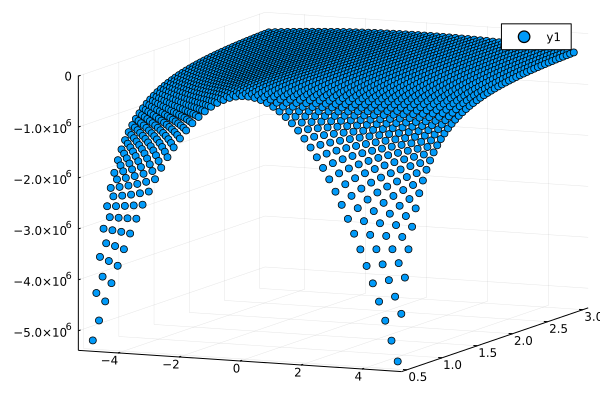

In [83]:
# Plotting our search grid
scatter(vals.m, vals.s, vals.lp)

## ThreadsX and easy parallelism

The stuff we've done before is somewhat complicated, in that we needed locks or other "tricks" to make multithreading not give us garbage results.

Fortunately, there's a package called `ThreadsX` that implements multithreaded versions of the functions in Julia's `Base`, stuff like

- `ThreadsX.map` and `ThreadsX.mapreduce` (super useful!)
- `ThreadsX.sum`
- `ThreadsX.extrema`
- `ThreadsX.sort`
- `ThreadsX.unique`
- And [others](https://github.com/tkf/ThreadsX.jl).

## ThreadsX and easy parallelism

For a lot of these functions, you can multithread and occasionally get free speed just by adding `ThreadsX.` in front of some big function you're doing.

In [6]:
using ThreadsX, BenchmarkTools

data = randn(10_000, 10_000)
@time sum(data)
@time ThreadsX.sum(data)

  0.044840 seconds (1 allocation: 16 bytes)
  0.031442 seconds (484 allocations: 29.812 KiB)


-12078.22215203096

## How threading performance scales with data size

Threading generally does better when you give threads more data -- give a thread ten easy to process data points, and you might just be better off saving yourself the hassle and just use a serial implementation instead!

For much larger datasets threading becomes a great idea, though slowly.

In [ ]:
using Plots

function sum_timer(data)
    t1 = @timed sum(data)
    t2 = @timed ThreadsX.sum(data)
    return (base=t1.time, threaded=t2.time)
end

ns = 100:5000:100_000
base = []
threaded = []
for n in ns
    data = randn(n, 1_000)
    b, t = sum_timer(data)
    push!(base, b)
    push!(threaded, t)
end

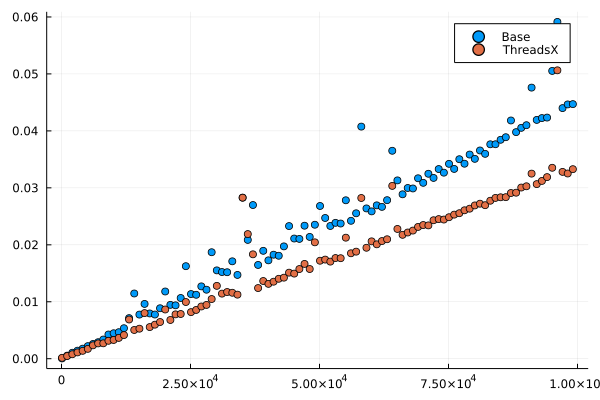

In [13]:
scatter(ns, base, label="Base")
scatter!(ns, threaded, label="ThreadsX")